In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras import initializers
from tensorflow.keras import layers
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import os
import h5py
import csv
import skimage.io
from sklearn.model_selection import KFold
import glob
from zipfile import ZipFile
import cv2
import dlib
from google.colab.patches import cv2_imshow
from skimage import io
from PIL import Image 
import matplotlib.pyplot as plt
import math
from zipfile import ZipFile
import PIL
from sklearn.model_selection import train_test_split

In [2]:
image_list =[]

anger = np.zeros((124))
happy = np.ones((128))
disgust = np.full((120),2)
fear = np.full((128),3)
sad = np.full((136),4)
surprise = np.full((120),5)
neutral = np.full((120),6)

labels = np.concatenate((anger,happy,disgust,fear,sad,surprise,neutral))

In [3]:
def plot_history(history):
  # function to plot accuracy vs epoch

  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')

In [4]:
def euclidean_distance(a, b):
  x1 = a[0]; y1 = a[1]
  x2 = b[0]; y2 = b[1]
  return math.sqrt(((x2 - x1) * (x2 - x1)) + ((y2 - y1) * (y2 - y1)))

In [11]:
file_name = "neu.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

# Run 7 times while changing file_name
# Remove desktop.ini file from the particular folder which gets added after running this cell, before running the next cell (except for neutral)

Done


In [50]:
path_lists = []
matrix_lists = []
for folder_name in os.listdir('/content/neu'):
  path_1 = os.path.join('/content/neu', folder_name)
  for file_name in os.listdir(path_1):
    path_2 = os.path.join(path_1, file_name)
    if os.path.isfile(path_2):
      path_lists.append(path_2)
      image = cv2.imread(path_2)
      matrix_lists.append(image)
print(path_lists)

# Run 7 times while changing file_name

['/content/neu/neutral/KL.NE2.156.jpg', '/content/neu/neutral/NM.NE1.92.jpg', '/content/neu/neutral/KR.NE1.71.jpg', '/content/neu/neutral/KM.NE3.3.jpg', '/content/neu/neutral/NA.NE3.201.jpg', '/content/neu/neutral/MK.NE3.115.jpg', '/content/neu/neutral/TM.NE3.179.jpg', '/content/neu/neutral/NA.NE1.199.jpg', '/content/neu/neutral/MK.NE1.113.jpg', '/content/neu/neutral/MK.NE2.114.jpg', '/content/neu/neutral/KM.NE1.1.jpg', '/content/neu/neutral/KA.NE2.27.jpg', '/content/neu/neutral/KL.NE1.155.jpg', '/content/neu/neutral/YM.NE2.50.jpg', '/content/neu/neutral/TM.NE1.177.jpg', '/content/neu/neutral/UY.NE2.135.jpg', '/content/neu/neutral/UY.NE1.134.jpg', '/content/neu/neutral/KM.NE2.2.jpg', '/content/neu/neutral/KA.NE1.26.jpg', '/content/neu/neutral/TM.NE2.178.jpg', '/content/neu/neutral/KL.NE3.157.jpg', '/content/neu/neutral/NM.NE2.93.jpg', '/content/neu/neutral/KA.NE3.28.jpg', '/content/neu/neutral/KR.NE3.73.jpg', '/content/neu/neutral/YM.NE1.49.jpg', '/content/neu/neutral/KR.NE2.72.jpg', '

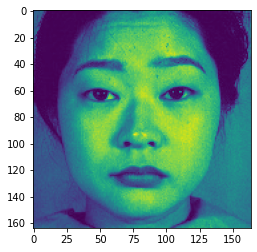

In [51]:
#face_cropping
gray_list=[]
cropped_img_list=[]
for img in matrix_lists:
  face_cascade=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
  gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  gray_list.append(gray)
  faces=face_cascade.detectMultiScale(gray,1.3,5,minSize=(100,100))
  face_x, face_y, face_w, face_h = faces[0]
  cropped_img= gray[int(face_y):int(face_y+face_h), int(face_x):int(face_x+face_w)]
  cropped_img_list.append(cropped_img)
plt.imshow(cropped_img_list[0])
    
# Run 7 times

In [52]:
#face_allignment
!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bunzip2 "shape_predictor_5_face_landmarks.dat.bz2"

# Run 7 times
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')
print(predictor)

# Run 7 times

--2020-07-08 18:45:27--  http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M)
Saving to: ‘shape_predictor_5_face_landmarks.dat.bz2.5’

shape_predictor_5_f 100%[===================>]   5.44M  1.59MB/s    in 3.4s    

2020-07-08 18:45:31 (1.59 MB/s) - ‘shape_predictor_5_face_landmarks.dat.bz2.5’ saved [5706710/5706710]

bunzip2: Output file shape_predictor_5_face_landmarks.dat already exists.


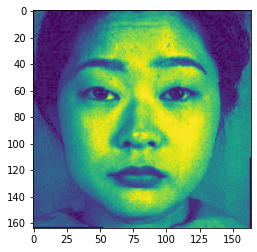

In [53]:
raw_img_list=[]
rotated_img_list=[]
for img in cropped_img_list:
  raw_img=img.copy()
  rects = detector(raw_img, 0)
  if len(rects) > 0:
    for rect in rects:
        x = rect.left()
        y = rect.top()
        w = rect.right()
        h = rect.bottom()
    landmarks = predictor(raw_img, rect)
    left_eye_left_x,left_eye_left_y,left_eye_right_x,left_eye_right_y=landmarks.part(2).x,landmarks.part(2).y,landmarks.part(3).x,landmarks.part(3).y
    right_eye_left_x,right_eye_left_y,right_eye_right_x,right_eye_right_y=landmarks.part(1).x,landmarks.part(1).y,landmarks.part(0).x,landmarks.part(0).y
    left_eye_center =((left_eye_left_x+left_eye_right_x)//2,(left_eye_left_y+left_eye_right_y)//2)
    right_eye_center =((right_eye_left_x+right_eye_right_x)//2,(right_eye_left_y+right_eye_right_y)//2)
    left_eye_x = left_eye_center[0]; left_eye_y = left_eye_center[1]
    right_eye_x = right_eye_center[0]; right_eye_y = right_eye_center[1]

    

    if left_eye_y < right_eye_y:
      point_3rd = (right_eye_x, left_eye_y)
      direction = 1 
      #rotate same direction to clock
    else:
      point_3rd = (left_eye_x, right_eye_y)
      direction = -1 #rotate inverse direction of clock

    a = euclidean_distance(left_eye_center, point_3rd)
    b = euclidean_distance(right_eye_center, left_eye_center)
    c = euclidean_distance(right_eye_center, point_3rd) 
    
    cos_a = (b*b + c*c - a*a)/(2*b*c) 
    angle = np.arccos(cos_a)
    angle = (angle * 180) / math.pi
    if direction == 1:
      angle = 90 - angle
    
    rotated_img = Image.fromarray(raw_img)


    
    rotated_img = np.array(rotated_img.rotate(direction * angle))
    rotated_img_list.append(rotated_img)
 
    

plt.imshow(rotated_img_list[0])

# Run 7 times

#histogram_equilization
histogram_list=[]
for img in rotated_img_list:
  
  equ = cv2.equalizeHist(img)
  histogram_list.append(equ)
plt.imshow(histogram_list[0])

# Run 7 times

In [16]:
#data_augmentation
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util

def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]


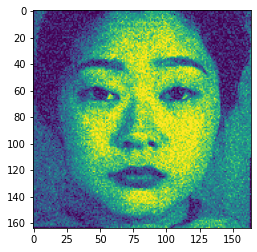

In [54]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img 
random_rotation_list=[]
for img in histogram_list:
  random_img=random_rotation(img)
  random_rotation_list.append(random_img)
plt.imshow(random_rotation_list[0])

# Run 7 times

flip_list=[]
for img in histogram_list:
  flipped_img=horizontal_flip(img)
  flip_list.append(flipped_img)
plt.imshow(flip_list[0])

# Run 7 times

noise_list=[]
for img in histogram_list:
  noise_image=random_noise(img)
  noise_list.append(noise_image)
plt.imshow(noise_list[0]) 

# Run 7 times

final_list=[]
for img in histogram_list:
  final_list.append(img)

for img in random_rotation_list:
  final_list.append(img)

for img in flip_list:
  final_list.append(img)

for img in noise_list:
  final_list.append(img)

# Run 7 times

In [55]:
for img in final_list:
  image_list.append(img)

# Run 7 times

In [49]:
print(len(image_list))

756


In [56]:
img_list = []
for img in image_list:
  img_list.append(img)

In [57]:
def get_pixel_value(img, center, x, y):
    
    new_value = 0
    
    try:
        # If neighbourhood pixel value >= center pixel value, then set it to 1
        if img[x][y] >= center:
            new_value = 1
            
    except:
        # Exception is required when neighbourhood value of a center pixel value is null i.e. values present at boundaries.
        pass
    
    return new_value

In [58]:
# Function for calculating LBP
def lbp_calculated_pixel(img, x, y):
    
    center = img[x][y]
    
    val_ar = []
    
    # top_left
    val_ar.append(get_pixel_value(img, center, x-1, y-1))
    
    # top
    val_ar.append(get_pixel_value(img, center, x-1, y))
    
    # top_right
    val_ar.append(get_pixel_value(img, center, x-1, y + 1))
    
    # right
    val_ar.append(get_pixel_value(img, center, x, y + 1))
    
    # bottom_right
    val_ar.append(get_pixel_value(img, center, x + 1, y + 1))
    
    # bottom
    val_ar.append(get_pixel_value(img, center, x + 1, y))
    
    # bottom_left
    val_ar.append(get_pixel_value(img, center, x + 1, y-1))
    
    # left
    val_ar.append(get_pixel_value(img, center, x, y-1))
    
    # Now, we need to convert binary values to decimal
    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    
    val = 0
    
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
        
    return val

In [59]:
ready_list = []

# Insert image path here
# path = r'C:\Users\hppc\Desktop\test.jpg'
# img_rgb = cv2.imread(path, 1)

for img in image_list:
    img_rgb = img
    
    height, width = img_rgb.shape

    # Converting RGB image into grayscale
    # img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

    # Create a numpy array as the same height and width of RGB image
    img_lbp = np.zeros((height, width), np.uint8) 

    for i in range(0, height):
        for j in range(0, width):
            img_lbp[i, j] = lbp_calculated_pixel(img_rgb, i, j)

    ready_list.append(img_lbp)

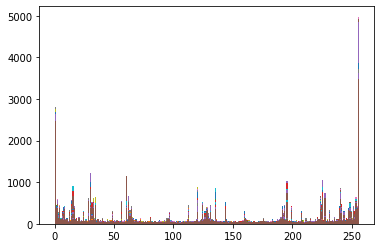

In [60]:
hist_list = []

for img in ready_list:
  hist = plt.hist(img.ravel(), 256, [0,256])
  hist_list.append(hist)

In [61]:
for i in range((len(image_list))):
  image_list[i] = np.resize(image_list[i], (128,128))

In [62]:
for i in range((len(ready_list))):
  ready_list[i] = np.resize(ready_list[i], (128,128))

In [ ]:
data_x = np.asarray(image_list) #if dtype=np.float32 gives an error, remove it.

In [63]:
data_x = np.asarray(ready_list, dtype=np.float32)

In [64]:
print(data_x.shape)

(876, 128, 128)


In [65]:
initializer = tf.keras.initializers.GlorotUniform(seed=None)

In [66]:
#check input shape
def cnn_model(input_shape=(128,128,1), num_classes=7):

  model = tf.keras.models.Sequential([tf.keras.layers.Dense(3, kernel_initializer=initializer),
                                      tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(128, 128,1)),
                                      tf.keras.layers.MaxPooling2D((2, 2), strides=2),
                                      tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
                                      tf.keras.layers.MaxPooling2D((2, 2), strides=2),
                                      tf.keras.layers.Flatten(),
                                      tf.keras.layers.Dropout(0.25),
                                      tf.keras.layers.Dense(7, activation=tf.nn.softmax)])
  
  return model  
  # This is the simple CNN model as was designed in the paper

In [ ]:
def cnn_model_custom(input_shape=(128, 128, 1), num_classes=7):

  model = tf.keras.models.Sequential([tf.keras.layers.Dense(3, kernel_initializer=initializer),
                                      tf.keras.layers.Conv2D(6, (5, 5), activation='relu', input_shape=(128, 128, 1)),
                                      tf.keras.layers.MaxPooling2D((2, 2)),
                                      tf.keras.layers.Conv2D(16, (5, 5), activation='relu'),
                                      tf.keras.layers.MaxPooling2D((2, 2)),
                                      tf.keras.layers.Conv2D(120, (5, 5), activation='relu'),
                                      tf.keras.layers.Dropout(0.25),
                                      tf.keras.layers.Flatten(),
                                      tf.keras.layers.Dense(64, activation=tf.nn.relu),
                                      tf.keras.layers.Dropout(0.4),
                                      tf.keras.layers.Dense(7, activation=tf.nn.softmax)])
  
  return model
  
  # This is the second CNN model as is built on the culmination of one other paper which yielded fantastic results for JAFFE dataset and one image classification stackoverflow link

In [ ]:
# This block is to be able to use the momentum optimizer while compiling CNN

lr = 0.001
momentum = 0.001
Momentum = tf.compat.v1.train.MomentumOptimizer(
    lr, momentum, name='Momentum', use_locking=False, use_nesterov=True
)

# Momentum optimizer, Nesterov can be used true or false depending on validation data

In [67]:
x_train, x_test, y_train, y_test = train_test_split(data_x, labels, train_size=0.75, shuffle=True)

x_train = x_train.reshape(x_train.shape[0], 128, 128, 1)
x_test = x_test.reshape(x_test.shape[0], 128, 128, 1)
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

print(x_train.shape)
print(y_test.shape)


(657, 128, 128, 1)
(219, 1)


In [ ]:
model = cnn_model()
#lr = 0.0001

model.compile(optimizer = Momentum,
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_test, y_test))
plot_history(history)
model.summary()

KFold(n_splits=10, random_state=None, shuffle=True)
Epoch 1/10
25/25 [==============================] - 28s 1s/step - loss: 35.1124 - accuracy: 0.1244 - val_loss: 8.8695 - val_accuracy: 0.2273
Epoch 2/10
25/25 [==============================] - 30s 1s/step - loss: 8.4135 - accuracy: 0.1967 - val_loss: 4.5017 - val_accuracy: 0.2273
Epoch 3/10
25/25 [==============================] - 28s 1s/step - loss: 3.0526 - accuracy: 0.3211 - val_loss: 2.3149 - val_accuracy: 0.2614
Epoch 4/10
25/25 [==============================] - 28s 1s/step - loss: 1.4606 - accuracy: 0.4581 - val_loss: 2.3553 - val_accuracy: 0.2159
Epoch 5/10
25/25 [==============================] - 28s 1s/step - loss: 0.9215 - accuracy: 0.6840 - val_loss: 2.3488 - val_accuracy: 0.2273
Epoch 6/10
25/25 [==============================] - 28s 1s/step - loss: 0.5068 - accuracy: 0.8401 - val_loss: 2.4781 - val_accuracy: 0.1932
Epoch 7/10
25/25 [==============================] - 28s 1s/step - loss: 0.2576 - accuracy: 0.9239 - val_los

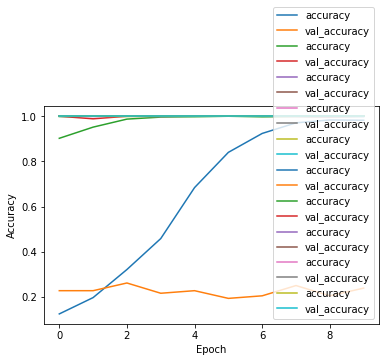

In [68]:
kf = KFold(n_splits=10, shuffle=True, random_state=None)
kf.get_n_splits(data_x)
print(kf)
lr = 0.0001
model = cnn_model()
model.compile(optimizer = tf.keras.optimizers.Adam(lr=lr),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
for train_index, test_index in kf.split(data_x, labels):
  X_train, X_test = data_x[train_index], data_x[test_index]
  Y_train, Y_test = labels[train_index], labels[test_index]
  X_train = X_train.reshape(X_train.shape[0], 128, 128, 1)
  X_test = X_test.reshape(X_test.shape[0], 128, 128, 1)
  Y_train = Y_train.reshape(Y_train.shape[0], 1)
  Y_test = Y_test.reshape(Y_test.shape[0], 1)

  history = model.fit(X_train, Y_train, epochs=10,
                      validation_data=(X_test, Y_test))
  plot_history(history)
  model.summary()

In [ ]:
model2 = cnn_model()
lr = 0.0001
model2.compile(optimizer = tf.keras.optimizers.Adam(lr=lr),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
model2.fit(x_train, y_train, epochs=10)

Epoch 1/10
21/21 [==============================] - 26s 1s/step - loss: 62.6469 - accuracy: 0.1659
Epoch 2/10
21/21 [==============================] - 26s 1s/step - loss: 19.7832 - accuracy: 0.1811
Epoch 3/10
21/21 [==============================] - 26s 1s/step - loss: 6.1327 - accuracy: 0.2435
Epoch 4/10
21/21 [==============================] - 26s 1s/step - loss: 2.1995 - accuracy: 0.3364
Epoch 5/10
21/21 [==============================] - 26s 1s/step - loss: 1.3731 - accuracy: 0.5145
Epoch 6/10
21/21 [==============================] - 26s 1s/step - loss: 0.9584 - accuracy: 0.6530
Epoch 7/10
21/21 [==============================] - 26s 1s/step - loss: 0.5920 - accuracy: 0.8158
Epoch 8/10
21/21 [==============================] - 26s 1s/step - loss: 0.2899 - accuracy: 0.9239
Epoch 9/10
21/21 [==============================] - 27s 1s/step - loss: 0.1794 - accuracy: 0.9513
Epoch 10/10
21/21 [==============================] - 26s 1s/step - loss: 0.1036 - accuracy: 0.9802


In [ ]:
print(model2.predict(x_test))

[[1.9758619e-01 2.6702744e-01 4.4994410e-03 ... 9.3788927e-04
  8.9185461e-03 1.1920974e-03]
 [9.8237023e-02 2.7386818e-02 3.1451363e-02 ... 6.0678101e-01
  8.7239467e-02 1.3620136e-02]
 [5.5172089e-03 1.0507840e-02 1.5420621e-04 ... 9.7518216e-04
  5.2689052e-01 2.3937272e-03]
 ...
 [3.2985329e-03 1.0357314e-01 8.0790790e-03 ... 5.0772387e-01
  5.0794132e-02 9.6930552e-04]
 [3.1309279e-03 1.0055334e-02 5.5203168e-03 ... 2.1663347e-02
  7.2058338e-01 1.7422201e-03]
 [7.6872192e-02 2.9618075e-01 7.7920139e-02 ... 6.5964989e-02
  6.1172405e-03 1.8860074e-02]]
